In [1]:
from PIL import Image
import numpy as np
from numba import jit
np.set_printoptions(precision=8)
from math import ceil

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

resume = 'binput-prerprelu-pg-resnet20.pt'
loaded_dict = torch.load(resume, map_location = 'cpu')

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=False, num_workers=1, 
                                          pin_memory=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                             shuffle=False, num_workers=1, 
                                             pin_memory=True, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# dataiter = iter(trainloader)
# for images, labels in dataiter:
#     print(labels)
# images, labels = dataiter.next()

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def numpy2bin(filename, np2write):
    s = np2write.shape
    with open(filename, "wb") as f:
        f.write(np2write.flatten())

    data = np.fromfile(filename, dtype=np.float32)
    data_recon = np.array(data).reshape(s)
    # print(data_recon)
    if data_recon.all() == np2write.all():
        print('GOOD')

In [4]:
def diff(a, b):
    count = 0
    if a.shape != b.shape:
        return False
    for d0 in range(a.shape[0]):
        for d1 in range(a.shape[1]):
            for d2 in range(a.shape[2]):
                for d3 in range(a.shape[3]):
                    if a[d0][d1][d2][d3] != b[d0][d1][d2][d3]:
                        count += 1
    print(count)
#                         print('(%d, %d, %d, %d)'%(d0, d1, d2, d3))
#                         print('a = %.4f, b = %.4f'%(a[d0][d1][d2][d3], b[d0][d1][d2][d3]))

In [5]:
@jit
def thermometer_encoding(f_in, encoder_placeholder):
    # in_size = (1, 3, 32, 32)
    # out_size = (1, 96, 32, 32)
    
    f_out = np.zeros((1, 96, 32, 32))
                       
    for n in range(1):
        for c_in in range(3):
            for c_res in range(32):
                for h in range(32):
                    for w in range(32):
                        c_out = c_in*32 + c_res
                        thermo_value = f_in[n][c_in][h][w]
                        rounded = np.round(thermo_value*255.0/int(8))
                        if rounded > c_res:
                            f_out[n][c_out][h][w] = 1
                        else:
                            f_out[n][c_out][h][w] = -1
    return f_out

In [6]:
@jit
def conv1(f_in, w_in):
    f_out = np.zeros((1, 16, 32, 32))
    
    for n in range(1):
        for c_out in range(16):
            for row in range(32):
                for col in range(32):
                    accum = 0
                    for c_in in range(96):
                        for k_row in range(3):
                            for k_col in range(3):
                                row_in = row + k_row - 1
                                col_in = col + k_col - 1
                                if row_in >= 0 and row_in < 32 and col_in >= 0 and col_in < 32:
                                    inp = f_in[n][c_in][row_in][col_in]
                                    w = w_in[c_out][c_in][k_row][k_col]
                                    if (inp == 1 and w > 0) or (inp == -1 and w <= 0):
                                        accum += 1
                                    else:
                                        accum -= 1
#                                 accum += f_in_padded[n][c_in][row + k_row][col + k_col]*w_in[c_out][c_in][k_row][k_col]
                    f_out[n][c_out][row][col] = accum
    return f_out

In [7]:
def bn1(f_in, weight, bias):
    
    # in_size = (1, 16, 32, 32)
    # mean, var, weight, bias size = (16,
    
    f_out = np.zeros(f_in.shape)
    
    for n in range(1):
        for c in range(f_out.shape[1]):
            f_out[n][c] = f_in[n][c]*weight[c] + bias[c]
    
    return f_out

In [8]:
@jit
def quant_sign(f_in):
    s = f_in.shape
    f_in = f_in.flatten()
    f_out = np.zeros(f_in.shape[0])
    for i in range(f_in.shape[0]):
        x = f_in[i]
        if x > 2/3:
            f_out[i] = 1
        elif x <= 2/3 and x >= 0:
            f_out[i] = 1/3
        elif x < 0 and x >= -2/3:
            f_out[i] = -1/3
        else:
            f_out[i] = -1
    return f_out.reshape(s)

In [9]:
@jit
def truncate(f_in):
    s = f_in.shape
    f_in = f_in.flatten()
    f_out = np.zeros(f_in.shape[0])
    for i in range(f_in.shape[0]):
        x = f_in[i]
        if x >= 0:
            f_out[i] = 1/3
        else:
            f_out[i] = -1
    return f_out.reshape(s)

In [10]:
@jit
def gen_conv1(f_in, weight, stride):
    si = f_in.shape
    sw = weight.shape
#     do = ceil(si[2]/stride)
    do = int(si[2]/stride)
    f_o = np.zeros(shape=(1, sw[0], do, do), dtype=np.float32)
    for n in range(1):
        for co in range(sw[0]):
            for row in range(do):
                for col in range(do):
                    accum = 0
                    for ci in range(sw[1]):
                        for krow in range(sw[2]):
                            for kcol in range(sw[3]):
                                row_in = row*stride + krow - 1
                                col_in = col*stride + kcol - 1
                                if row_in >= 0 and row_in < f_in.shape[2] and col_in >= 0 and col_in < f_in.shape[2]:
                                    accum += f_in[n][ci][row_in][col_in]*weight[co][ci][krow][kcol]
#                                 else:
#                                     accum += 0
                    f_o[n][co][row][col] = accum 
    return f_o

In [11]:
def fuse_bn(weight, bias, mean, var):
    fused_weight = weight/np.sqrt(var - 1e-5)
    fused_bias = bias - mean*weight/np.sqrt(var - 1e-5)
    return fused_weight, fused_bias

In [12]:
@jit
def sigmoid(x):
#     out = x/(1 + abs(x))/2 + 0.5
    out = 1/(1+ np.exp(-x))
    return out

In [13]:
@jit
def layer1_0_pgconv1(f_in, weight, threshold):
    f_out = np.zeros((1, 16, 32, 32))
    f_in_truncate = truncate(f_in)
    out_msb = gen_conv1(f_in_truncate, weight, 1)
    full_msb = gen_conv1(f_in, weight, 1)
    for n in range(1):
        for co in range(16):
            for row in range(32):
                for col in range(32):
                    if sigmoid(5*(out_msb[n][co][row][col] - threshold[0][co][0][0])) > 0.5:
                        f_out[n][co][row][col] = full_msb[n][co][row][col]
                    else:
                        f_out[n][co][row][col] = out_msb[n][co][row][col]
    return f_out

In [14]:
@jit
def layer2_0_pgconv1(f_in, weight, threshold):
    f_out = np.zeros((1, 32, 16, 16))
    f_in_truncate = truncate(f_in)
    s = 1
    if weight.shape[0] != weight.shape[1]:
        s = 2
    out_msb = gen_conv1(f_in_truncate, weight, s)
    full_msb = gen_conv1(f_in, weight, s)
    for n in range(1):
        for co in range(32):
            for row in range(16):
                for col in range(16):
                    if sigmoid(5*(out_msb[n][co][row][col] - threshold[0][co][0][0])) > 0.5:
                        f_out[n][co][row][col] = full_msb[n][co][row][col]
                    else:
                        f_out[n][co][row][col] = out_msb[n][co][row][col]
    return f_out

In [15]:
@jit
def layer3_0_pgconv1(f_in, weight, threshold):
    f_out = np.zeros((1, 64, 8, 8))
    f_in_truncate = truncate(f_in)
    s = 1
    if weight.shape[0] != weight.shape[1]:
        s = 2
    out_msb = gen_conv1(f_in_truncate, weight, s)
    full_msb = gen_conv1(f_in, weight, s)
    for n in range(1):
        for co in range(64):
            for row in range(8):
                for col in range(8):
                    if sigmoid(5*(out_msb[n][co][row][col] - threshold[0][co][0][0])) > 0.5:
                        f_out[n][co][row][col] = full_msb[n][co][row][col]
                    else:
                        f_out[n][co][row][col] = out_msb[n][co][row][col]
    return f_out

In [16]:
@jit
def layer1_0_rprelu1(f_in, x_bias, y_bias, weight):
    f_out = np.zeros((1, 16, 32, 32))
    
    for n in range(1):
        for c in range(16):
            for h in range(32):
                for w in range(32):
                    t = f_in[n][c][h][w] + x_bias[0][c][0][0]
                    if t < 0:
                        t = weight[c]*t
                    f_out[n][c][h][w] = t + y_bias[0][c][0][0]
    return f_out

In [17]:
@jit
def layer2_0_rprelu1(f_in, x_bias, y_bias, weight):
    f_out = np.zeros((1, 32, 16, 16))
    
    for n in range(1):
        for c in range(32):
            for h in range(16):
                for w in range(16):
                    t = f_in[n][c][h][w] + x_bias[0][c][0][0]
                    if t < 0:
                        t = weight[c]*t
                    f_out[n][c][h][w] = t + y_bias[0][c][0][0]
    return f_out

In [18]:
@jit
def layer3_0_rprelu1(f_in, x_bias, y_bias, weight):
    f_out = np.zeros((1, 64, 8, 8))
    
    for n in range(1):
        for c in range(64):
            for h in range(8):
                for w in range(8):
                    t = f_in[n][c][h][w] + x_bias[0][c][0][0]
                    if t < 0:
                        t = weight[c]*t
                    f_out[n][c][h][w] = t + y_bias[0][c][0][0]
    return f_out

In [19]:
@jit
def avgpool_concat(f_in):
    s = f_in.shape
    f_out = np.zeros((1, s[1]*2, int(s[2]/2), int(s[3]/2)))
    for n in range(1):
        for c in range(s[1]):
            for row in range(f_out.shape[2]):
                for col in range(f_out.shape[3]):
                    m = (f_in[n][c][row*2][col*2] +
                           f_in[n][c][row*2][col*2+1] +
                           f_in[n][c][row*2+1][col*2] +
                           f_in[n][c][row*2+1][col*2+1])/4
                    f_out[n][c][row][col] = m
                    f_out[n][c+s[1]][row][col] = m
    return f_out

In [20]:
@jit
def avgpool(f_in):
    f_out = np.zeros((64,))
    for n in range(64):
        f_out[n] = np.mean(f_in[0][n])
    return f_out

In [21]:
# images = np.array(images, dtype = np.float64)
# print(images.shape)
# print(images)
# img = np.array(images*255.0)[0].transpose(1, 2, 0).astype(np.uint8)
# display(Image.fromarray(img))

In [22]:
# placeholder = new_dict['encoder.placeholder'].cpu().numpy()
# # print(placeholder.shape)
# # print(images[0][0][0][3])
# # print(images[0][0][6][14])
# # print(images[0][0][7][19])
# encoding_out = thermometer_encoding(images, placeholder)
# # print(encoding_out.shape)
# # print(encoding_out)
# conv1_weight = new_dict['conv1.weight'].cpu().numpy()
# # print(conv1_weight)
# # numpy2bin('weight_bins/conv1_weight2.bin', conv1_weight.transpose((0, 1, 3, 2)))

# bn1_weight = new_dict['bn1.weight'].cpu().numpy()
# bn1_bias = new_dict['bn1.bias'].cpu().numpy()
# bn1_running_mean = new_dict['bn1.running_mean'].cpu().numpy()
# bn1_running_var = new_dict['bn1.running_var'].cpu().numpy()
# # bn1_num_batches_tracked = new_dict['bn1.num_batches_tracked'].cpu().numpy()

# bn1_fused_weight = bn1_weight/np.sqrt(bn1_running_var - 1e-5)
# # numpy2bin('weight_bins/bn1_fused_weight.bin', bn1_fused_weight)
# bn1_fused_bias = bn1_bias - bn1_running_mean*bn1_weight/np.sqrt(bn1_running_var - 1e-5)
# # numpy2bin('weight_bins/bn1_fused_bias.bin', bn1_fused_bias)

# conv1_input_golden = np.load('conv1_input.npy')
# diff(conv1_input_golden, encoding_out)


In [23]:
def net(img, new_dict):
    placeholder = new_dict['encoder.placeholder'].cpu().numpy()
    encoding_out = thermometer_encoding(img, placeholder)
#     np.save('encoding_out.npy', encoding_out)
#     encoding_out = np.load('encoding_out.npy')
    
    conv1_weight = new_dict['conv1.weight'].cpu().numpy()
    conv1_out = conv1(encoding_out, conv1_weight)
    bn1_weight = new_dict['bn1.weight'].cpu().numpy()
    bn1_bias = new_dict['bn1.bias'].cpu().numpy()
    bn1_running_mean = new_dict['bn1.running_mean'].cpu().numpy()
    bn1_running_var = new_dict['bn1.running_var'].cpu().numpy()
    bn1_fused_weight = bn1_weight/np.sqrt(bn1_running_var - 1e-5)
    bn1_fused_bias = bn1_bias - bn1_running_mean*bn1_weight/np.sqrt(bn1_running_var - 1e-5)
    bn1_out = bn1(conv1_out, bn1_fused_weight, bn1_fused_bias)

    layer1_0_binarize1_out = quant_sign(bn1_out)

    layer1_0_conv1_weight = new_dict['layer1.0.conv1.weight'].cpu().numpy()
    layer1_0_conv1_threshold = new_dict['layer1.0.conv1.threshold'].cpu().numpy()
    layer1_0_pgconv1_out = layer1_0_pgconv1(layer1_0_binarize1_out, np.sign(layer1_0_conv1_weight), layer1_0_conv1_threshold)
    
    layer1_0_bn1_weight = new_dict['layer1.0.bn1.weight'].cpu().numpy()
    layer1_0_bn1_bias = new_dict['layer1.0.bn1.bias'].cpu().numpy()
    layer1_0_bn1_running_mean = new_dict['layer1.0.bn1.running_mean'].cpu().numpy()
    layer1_0_bn1_running_var = new_dict['layer1.0.bn1.running_var'].cpu().numpy()
    layer1_0_bn1_fused_weight, layer1_0_bn1_fused_bias = fuse_bn(layer1_0_bn1_weight, layer1_0_bn1_bias, layer1_0_bn1_running_mean, layer1_0_bn1_running_var)
    layer1_0_bn1_out = bn1(layer1_0_pgconv1_out, layer1_0_bn1_fused_weight, layer1_0_bn1_fused_bias)

    layer1_0_rprelu1_shift_x_bias = new_dict['layer1.0.rprelu1.shift_x.bias'].cpu().numpy()
    layer1_0_rprelu1_shift_y_bias = new_dict['layer1.0.rprelu1.shift_y.bias'].cpu().numpy()
    layer1_0_rprelu1_prelu_weight = new_dict['layer1.0.rprelu1.prelu.weight'].cpu().numpy()
    layer1_0_rprelu1_out = layer1_0_rprelu1(layer1_0_bn1_out, layer1_0_rprelu1_shift_x_bias, layer1_0_rprelu1_shift_y_bias, layer1_0_rprelu1_prelu_weight)
    
    layer1_0_shortcut1_out = layer1_0_rprelu1_out + bn1_out

    layer1_0_bn3_weight = new_dict['layer1.0.bn3.weight'].cpu().numpy()
    layer1_0_bn3_bias = new_dict['layer1.0.bn3.bias'].cpu().numpy()
    layer1_0_bn3_running_mean = new_dict['layer1.0.bn3.running_mean'].cpu().numpy()
    layer1_0_bn3_running_var = new_dict['layer1.0.bn3.running_var'].cpu().numpy()
    layer1_0_bn3_fused_weight, layer1_0_bn3_fused_bias = fuse_bn(layer1_0_bn3_weight, layer1_0_bn3_bias, layer1_0_bn3_running_mean, layer1_0_bn3_running_var)
    layer1_0_bn3_out = bn1(layer1_0_shortcut1_out, layer1_0_bn3_fused_weight, layer1_0_bn3_fused_bias)

    layer1_0_binarize2_out = quant_sign(layer1_0_bn3_out)

    layer1_0_conv2_weight = new_dict['layer1.0.conv2.weight'].cpu().numpy()
    layer1_0_conv2_threshold = new_dict['layer1.0.conv2.threshold'].cpu().numpy()
    layer1_0_pgconv2_out = layer1_0_pgconv1(layer1_0_binarize2_out, np.sign(layer1_0_conv2_weight), layer1_0_conv2_threshold)

    layer1_0_bn2_weight = new_dict['layer1.0.bn2.weight'].cpu().numpy()
    layer1_0_bn2_bias = new_dict['layer1.0.bn2.bias'].cpu().numpy()
    layer1_0_bn2_running_mean = new_dict['layer1.0.bn2.running_mean'].cpu().numpy()
    layer1_0_bn2_running_var = new_dict['layer1.0.bn2.running_var'].cpu().numpy()
    layer1_0_bn2_fused_weight, layer1_0_bn2_fused_bias = fuse_bn(layer1_0_bn2_weight, layer1_0_bn2_bias, layer1_0_bn2_running_mean, layer1_0_bn2_running_var)
    layer1_0_bn2_out = bn1(layer1_0_pgconv2_out, layer1_0_bn2_fused_weight, layer1_0_bn2_fused_bias)

    layer1_0_rprelu2_shift_x_bias = new_dict['layer1.0.rprelu2.shift_x.bias'].cpu().numpy()
    layer1_0_rprelu2_shift_y_bias = new_dict['layer1.0.rprelu2.shift_y.bias'].cpu().numpy()
    layer1_0_rprelu2_prelu_weight = new_dict['layer1.0.rprelu2.prelu.weight'].cpu().numpy()
    layer1_0_rprelu2_out = layer1_0_rprelu1(layer1_0_bn2_out, layer1_0_rprelu2_shift_x_bias, layer1_0_rprelu2_shift_y_bias, layer1_0_rprelu2_prelu_weight)

    layer1_0_shortcut2_out = layer1_0_rprelu2_out + layer1_0_bn3_out

    layer1_0_bn4_weight = new_dict['layer1.0.bn4.weight'].cpu().numpy()
    layer1_0_bn4_bias = new_dict['layer1.0.bn4.bias'].cpu().numpy()
    layer1_0_bn4_running_mean = new_dict['layer1.0.bn4.running_mean'].cpu().numpy()
    layer1_0_bn4_running_var = new_dict['layer1.0.bn4.running_var'].cpu().numpy()
    layer1_0_bn4_fused_weight, layer1_0_bn4_fused_bias = fuse_bn(layer1_0_bn4_weight, layer1_0_bn4_bias, layer1_0_bn4_running_mean, layer1_0_bn4_running_var)
    layer1_0_bn4_out = bn1(layer1_0_shortcut2_out, layer1_0_bn4_fused_weight, layer1_0_bn4_fused_bias)
    
    layer1_1_binarize1_out = quant_sign(layer1_0_bn4_out)

    layer1_1_conv1_weight = new_dict['layer1.1.conv1.weight'].cpu().numpy()
    layer1_1_conv1_threshold = new_dict['layer1.1.conv1.threshold'].cpu().numpy()
    layer1_1_pgconv1_out = layer1_0_pgconv1(layer1_1_binarize1_out, np.sign(layer1_1_conv1_weight), layer1_1_conv1_threshold)

    layer1_1_bn1_weight = new_dict['layer1.1.bn1.weight'].cpu().numpy()
    layer1_1_bn1_bias = new_dict['layer1.1.bn1.bias'].cpu().numpy()
    layer1_1_bn1_running_mean = new_dict['layer1.1.bn1.running_mean'].cpu().numpy()
    layer1_1_bn1_running_var = new_dict['layer1.1.bn1.running_var'].cpu().numpy()
    layer1_1_bn1_fused_weight, layer1_1_bn1_fused_bias = fuse_bn(layer1_1_bn1_weight, layer1_1_bn1_bias, layer1_1_bn1_running_mean, layer1_1_bn1_running_var)
    layer1_1_bn1_out = bn1(layer1_1_pgconv1_out, layer1_1_bn1_fused_weight, layer1_1_bn1_fused_bias)

    layer1_1_rprelu1_shift_x_bias = new_dict['layer1.1.rprelu1.shift_x.bias'].cpu().numpy()
    layer1_1_rprelu1_shift_y_bias = new_dict['layer1.1.rprelu1.shift_y.bias'].cpu().numpy()
    layer1_1_rprelu1_prelu_weight = new_dict['layer1.1.rprelu1.prelu.weight'].cpu().numpy()
    layer1_1_rprelu1_out = layer1_0_rprelu1(layer1_1_bn1_out, layer1_1_rprelu1_shift_x_bias, layer1_1_rprelu1_shift_y_bias, layer1_1_rprelu1_prelu_weight)

    layer1_1_shortcut1_out = layer1_1_rprelu1_out + layer1_0_bn4_out

    layer1_1_bn3_weight = new_dict['layer1.1.bn3.weight'].cpu().numpy()
    layer1_1_bn3_bias = new_dict['layer1.1.bn3.bias'].cpu().numpy()
    layer1_1_bn3_running_mean = new_dict['layer1.1.bn3.running_mean'].cpu().numpy()
    layer1_1_bn3_running_var = new_dict['layer1.1.bn3.running_var'].cpu().numpy()
    layer1_1_bn3_fused_weight, layer1_1_bn3_fused_bias = fuse_bn(layer1_1_bn3_weight, layer1_1_bn3_bias, layer1_1_bn3_running_mean, layer1_1_bn3_running_var)
    layer1_1_bn3_out = bn1(layer1_1_shortcut1_out, layer1_1_bn3_fused_weight, layer1_1_bn3_fused_bias)

    layer1_1_binarize2_out = quant_sign(layer1_1_bn3_out)

    layer1_1_conv2_weight = new_dict['layer1.1.conv2.weight'].cpu().numpy()
    layer1_1_conv2_threshold = new_dict['layer1.1.conv2.threshold'].cpu().numpy()
    layer1_1_pgconv2_out = layer1_0_pgconv1(layer1_1_binarize2_out, np.sign(layer1_1_conv2_weight), layer1_1_conv2_threshold)

    layer1_1_bn2_weight = new_dict['layer1.1.bn2.weight'].cpu().numpy()
    layer1_1_bn2_bias = new_dict['layer1.1.bn2.bias'].cpu().numpy()
    layer1_1_bn2_running_mean = new_dict['layer1.1.bn2.running_mean'].cpu().numpy()
    layer1_1_bn2_running_var = new_dict['layer1.1.bn2.running_var'].cpu().numpy()
    layer1_1_bn2_fused_weight, layer1_1_bn2_fused_bias = fuse_bn(layer1_1_bn2_weight, layer1_1_bn2_bias, layer1_1_bn2_running_mean, layer1_1_bn2_running_var)
    layer1_1_bn2_out = bn1(layer1_1_pgconv2_out, layer1_1_bn2_fused_weight, layer1_1_bn2_fused_bias)

    layer1_1_rprelu2_shift_x_bias = new_dict['layer1.1.rprelu2.shift_x.bias'].cpu().numpy()
    layer1_1_rprelu2_shift_y_bias = new_dict['layer1.1.rprelu2.shift_y.bias'].cpu().numpy()
    layer1_1_rprelu2_prelu_weight = new_dict['layer1.1.rprelu2.prelu.weight'].cpu().numpy()
    layer1_1_rprelu2_out = layer1_0_rprelu1(layer1_1_bn2_out, layer1_1_rprelu2_shift_x_bias, layer1_1_rprelu2_shift_y_bias, layer1_1_rprelu2_prelu_weight)

    layer1_1_shortcut2_out = layer1_1_rprelu2_out + layer1_1_bn3_out

    layer1_1_bn4_weight = new_dict['layer1.1.bn4.weight'].cpu().numpy()
    layer1_1_bn4_bias = new_dict['layer1.1.bn4.bias'].cpu().numpy()
    layer1_1_bn4_running_mean = new_dict['layer1.1.bn4.running_mean'].cpu().numpy()
    layer1_1_bn4_running_var = new_dict['layer1.1.bn4.running_var'].cpu().numpy()
    layer1_1_bn4_fused_weight, layer1_1_bn4_fused_bias = fuse_bn(layer1_1_bn4_weight, layer1_1_bn4_bias, layer1_1_bn4_running_mean, layer1_1_bn4_running_var)
    layer1_1_bn4_out = bn1(layer1_1_shortcut2_out, layer1_1_bn4_fused_weight, layer1_1_bn4_fused_bias)

    layer1_2_binarize1_out = quant_sign(layer1_1_bn4_out)

    layer1_2_conv1_weight = new_dict['layer1.2.conv1.weight'].cpu().numpy()
    layer1_2_conv1_threshold = new_dict['layer1.2.conv1.threshold'].cpu().numpy()
    layer1_2_pgconv1_out = layer1_0_pgconv1(layer1_2_binarize1_out, np.sign(layer1_2_conv1_weight), layer1_2_conv1_threshold)

    layer1_2_bn1_weight = new_dict['layer1.2.bn1.weight'].cpu().numpy()
    layer1_2_bn1_bias = new_dict['layer1.2.bn1.bias'].cpu().numpy()
    layer1_2_bn1_running_mean = new_dict['layer1.2.bn1.running_mean'].cpu().numpy()
    layer1_2_bn1_running_var = new_dict['layer1.2.bn1.running_var'].cpu().numpy()
    layer1_2_bn1_fused_weight, layer1_2_bn1_fused_bias = fuse_bn(layer1_2_bn1_weight, layer1_2_bn1_bias, layer1_2_bn1_running_mean, layer1_2_bn1_running_var)
    layer1_2_bn1_out = bn1(layer1_2_pgconv1_out, layer1_2_bn1_fused_weight, layer1_2_bn1_fused_bias)

    layer1_2_rprelu1_shift_x_bias = new_dict['layer1.2.rprelu1.shift_x.bias'].cpu().numpy()
    layer1_2_rprelu1_shift_y_bias = new_dict['layer1.2.rprelu1.shift_y.bias'].cpu().numpy()
    layer1_2_rprelu1_prelu_weight = new_dict['layer1.2.rprelu1.prelu.weight'].cpu().numpy()
    layer1_2_rprelu1_out = layer1_0_rprelu1(layer1_2_bn1_out, layer1_2_rprelu1_shift_x_bias, layer1_2_rprelu1_shift_y_bias, layer1_2_rprelu1_prelu_weight)

    layer1_2_shortcut1_out = layer1_2_rprelu1_out + layer1_1_bn4_out

    layer1_2_bn3_weight = new_dict['layer1.2.bn3.weight'].cpu().numpy()
    layer1_2_bn3_bias = new_dict['layer1.2.bn3.bias'].cpu().numpy()
    layer1_2_bn3_running_mean = new_dict['layer1.2.bn3.running_mean'].cpu().numpy()
    layer1_2_bn3_running_var = new_dict['layer1.2.bn3.running_var'].cpu().numpy()
    layer1_2_bn3_fused_weight, layer1_2_bn3_fused_bias = fuse_bn(layer1_2_bn3_weight, layer1_2_bn3_bias, layer1_2_bn3_running_mean, layer1_2_bn3_running_var)
    layer1_2_bn3_out = bn1(layer1_2_shortcut1_out, layer1_2_bn3_fused_weight, layer1_2_bn3_fused_bias)

    layer1_2_binarize2_out = quant_sign(layer1_2_bn3_out)

    layer1_2_conv2_weight = new_dict['layer1.2.conv2.weight'].cpu().numpy()
    layer1_2_conv2_threshold = new_dict['layer1.2.conv2.threshold'].cpu().numpy()
    layer1_2_pgconv2_out = layer1_0_pgconv1(layer1_2_binarize2_out, np.sign(layer1_2_conv2_weight), layer1_2_conv2_threshold)

    layer1_2_bn2_weight = new_dict['layer1.2.bn2.weight'].cpu().numpy()
    layer1_2_bn2_bias = new_dict['layer1.2.bn2.bias'].cpu().numpy()
    layer1_2_bn2_running_mean = new_dict['layer1.2.bn2.running_mean'].cpu().numpy()
    layer1_2_bn2_running_var = new_dict['layer1.2.bn2.running_var'].cpu().numpy()
    layer1_2_bn2_fused_weight, layer1_2_bn2_fused_bias = fuse_bn(layer1_2_bn2_weight, layer1_2_bn2_bias, layer1_2_bn2_running_mean, layer1_2_bn2_running_var)
    layer1_2_bn2_out = bn1(layer1_2_pgconv2_out, layer1_2_bn2_fused_weight, layer1_2_bn2_fused_bias)

    layer1_2_rprelu2_shift_x_bias = new_dict['layer1.2.rprelu2.shift_x.bias'].cpu().numpy()
    layer1_2_rprelu2_shift_y_bias = new_dict['layer1.2.rprelu2.shift_y.bias'].cpu().numpy()
    layer1_2_rprelu2_prelu_weight = new_dict['layer1.2.rprelu2.prelu.weight'].cpu().numpy()
    layer1_2_rprelu2_out = layer1_0_rprelu1(layer1_2_bn2_out, layer1_2_rprelu2_shift_x_bias, layer1_2_rprelu2_shift_y_bias, layer1_2_rprelu2_prelu_weight)

    layer1_2_shortcut2_out = layer1_2_rprelu2_out + layer1_2_bn3_out

    layer1_2_bn4_weight = new_dict['layer1.2.bn4.weight'].cpu().numpy()
    layer1_2_bn4_bias = new_dict['layer1.2.bn4.bias'].cpu().numpy()
    layer1_2_bn4_running_mean = new_dict['layer1.2.bn4.running_mean'].cpu().numpy()
    layer1_2_bn4_running_var = new_dict['layer1.2.bn4.running_var'].cpu().numpy()
    layer1_2_bn4_fused_weight, layer1_2_bn4_fused_bias = fuse_bn(layer1_2_bn4_weight, layer1_2_bn4_bias, layer1_2_bn4_running_mean, layer1_2_bn4_running_var)
    layer1_2_bn4_out = bn1(layer1_2_shortcut2_out, layer1_2_bn4_fused_weight, layer1_2_bn4_fused_bias)

#     print('layer1')
#     print(layer1_2_bn4_out)

    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################


    layer2_0_binarize1_out = quant_sign(layer1_2_bn4_out)
#     print('layer2_0_binarize1_out')
#     print(layer2_0_binarize1_out)

    layer2_0_conv1_weight = new_dict['layer2.0.conv1.weight'].cpu().numpy()
    layer2_0_conv1_threshold = new_dict['layer2.0.conv1.threshold'].cpu().numpy()
    layer2_0_pgconv1_out = layer2_0_pgconv1(layer2_0_binarize1_out, np.sign(layer2_0_conv1_weight), layer2_0_conv1_threshold)
#     print('layer2_0_pgconv1_out')
#     print(layer2_0_pgconv1_out)

    layer2_0_bn1_weight = new_dict['layer2.0.bn1.weight'].cpu().numpy()
    layer2_0_bn1_bias = new_dict['layer2.0.bn1.bias'].cpu().numpy()
    layer2_0_bn1_running_mean = new_dict['layer2.0.bn1.running_mean'].cpu().numpy()
    layer2_0_bn1_running_var = new_dict['layer2.0.bn1.running_var'].cpu().numpy()
    layer2_0_bn1_fused_weight, layer2_0_bn1_fused_bias = fuse_bn(layer2_0_bn1_weight, layer2_0_bn1_bias, layer2_0_bn1_running_mean, layer2_0_bn1_running_var)
    layer2_0_bn1_out = bn1(layer2_0_pgconv1_out, layer2_0_bn1_fused_weight, layer2_0_bn1_fused_bias)
#     print('layer2_0_bn1_out')
#     print(layer2_0_bn1_out)

    layer2_0_rprelu1_shift_x_bias = new_dict['layer2.0.rprelu1.shift_x.bias'].cpu().numpy()
    layer2_0_rprelu1_shift_y_bias = new_dict['layer2.0.rprelu1.shift_y.bias'].cpu().numpy()
    layer2_0_rprelu1_prelu_weight = new_dict['layer2.0.rprelu1.prelu.weight'].cpu().numpy()
    layer2_0_rprelu1_out = layer2_0_rprelu1(layer2_0_bn1_out, layer2_0_rprelu1_shift_x_bias, layer2_0_rprelu1_shift_y_bias, layer2_0_rprelu1_prelu_weight)

    layer2_0_shortcut1_out = avgpool_concat(layer1_2_bn4_out)
#     print('layer2_0_shortcut1_out')
    # print(layer2_0_concat_out.shape)
#     print(layer2_0_shortcut1_out)

    layer2_0_concat_out = layer2_0_rprelu1_out + layer2_0_shortcut1_out
#     print('layer2_0_concat_out')
    # print(layer2_0_concat_out.shape)
#     print(layer2_0_concat_out)

    layer2_0_bn3_weight = new_dict['layer2.0.bn3.weight'].cpu().numpy()
    layer2_0_bn3_bias = new_dict['layer2.0.bn3.bias'].cpu().numpy()
    layer2_0_bn3_running_mean = new_dict['layer2.0.bn3.running_mean'].cpu().numpy()
    layer2_0_bn3_running_var = new_dict['layer2.0.bn3.running_var'].cpu().numpy()
    layer2_0_bn3_fused_weight, layer2_0_bn3_fused_bias = fuse_bn(layer2_0_bn3_weight, layer2_0_bn3_bias, layer2_0_bn3_running_mean, layer2_0_bn3_running_var)
    layer2_0_bn3_out = bn1(layer2_0_concat_out, layer2_0_bn3_fused_weight, layer2_0_bn3_fused_bias)
    # print('layer2_0_bn3_out')
    # print(layer2_0_bn3_out.shape)
    # print(layer2_0_bn3_out)

    layer2_0_binarize2_out = quant_sign(layer2_0_bn3_out)

    layer2_0_conv2_weight = new_dict['layer2.0.conv2.weight'].cpu().numpy()
    layer2_0_conv2_threshold = new_dict['layer2.0.conv2.threshold'].cpu().numpy()
    layer2_0_pgconv2_out = layer2_0_pgconv1(layer2_0_binarize2_out, np.sign(layer2_0_conv2_weight), layer2_0_conv2_threshold)

    layer2_0_bn2_weight = new_dict['layer2.0.bn2.weight'].cpu().numpy()
    layer2_0_bn2_bias = new_dict['layer2.0.bn2.bias'].cpu().numpy()
    layer2_0_bn2_running_mean = new_dict['layer2.0.bn2.running_mean'].cpu().numpy()
    layer2_0_bn2_running_var = new_dict['layer2.0.bn2.running_var'].cpu().numpy()
    layer2_0_bn2_fused_weight, layer2_0_bn2_fused_bias = fuse_bn(layer2_0_bn2_weight, layer2_0_bn2_bias, layer2_0_bn2_running_mean, layer2_0_bn2_running_var)
    layer2_0_bn2_out = bn1(layer2_0_pgconv2_out, layer2_0_bn2_fused_weight, layer2_0_bn2_fused_bias)

    layer2_0_rprelu2_shift_x_bias = new_dict['layer2.0.rprelu2.shift_x.bias'].cpu().numpy()
    layer2_0_rprelu2_shift_y_bias = new_dict['layer2.0.rprelu2.shift_y.bias'].cpu().numpy()
    layer2_0_rprelu2_prelu_weight = new_dict['layer2.0.rprelu2.prelu.weight'].cpu().numpy()
    layer2_0_rprelu2_out = layer2_0_rprelu1(layer2_0_bn2_out, layer2_0_rprelu2_shift_x_bias, layer2_0_rprelu2_shift_y_bias, layer2_0_rprelu2_prelu_weight)

    layer2_0_shortcut2_out = layer2_0_rprelu2_out + layer2_0_bn3_out
    # print('layer2_0_shortcut2_out')
    # print(layer2_0_shortcut2_out.shape)
    # print(layer2_0_shortcut2_out)

    layer2_0_bn4_weight = new_dict['layer2.0.bn4.weight'].cpu().numpy()
    layer2_0_bn4_bias = new_dict['layer2.0.bn4.bias'].cpu().numpy()
    layer2_0_bn4_running_mean = new_dict['layer2.0.bn4.running_mean'].cpu().numpy()
    layer2_0_bn4_running_var = new_dict['layer2.0.bn4.running_var'].cpu().numpy()
    layer2_0_bn4_fused_weight, layer2_0_bn4_fused_bias = fuse_bn(layer2_0_bn4_weight, layer2_0_bn4_bias, layer2_0_bn4_running_mean, layer2_0_bn4_running_var)
    layer2_0_bn4_out = bn1(layer2_0_shortcut2_out, layer2_0_bn4_fused_weight, layer2_0_bn4_fused_bias)
    # print('layer2_0_bn4_out')
    # print(layer2_0_bn4_out.shape)
#     print(layer2_0_bn4_out)

    layer2_1_binarize1_out = quant_sign(layer2_0_bn4_out)

    layer2_1_conv1_weight = new_dict['layer2.1.conv1.weight'].cpu().numpy()
    layer2_1_conv1_threshold = new_dict['layer2.1.conv1.threshold'].cpu().numpy()
    layer2_1_pgconv1_out = layer2_0_pgconv1(layer2_1_binarize1_out, np.sign(layer2_1_conv1_weight), layer2_1_conv1_threshold)

    layer2_1_bn1_weight = new_dict['layer2.1.bn1.weight'].cpu().numpy()
    layer2_1_bn1_bias = new_dict['layer2.1.bn1.bias'].cpu().numpy()
    layer2_1_bn1_running_mean = new_dict['layer2.1.bn1.running_mean'].cpu().numpy()
    layer2_1_bn1_running_var = new_dict['layer2.1.bn1.running_var'].cpu().numpy()
    layer2_1_bn1_fused_weight, layer2_1_bn1_fused_bias = fuse_bn(layer2_1_bn1_weight, layer2_1_bn1_bias, layer2_1_bn1_running_mean, layer2_1_bn1_running_var)
    layer2_1_bn1_out = bn1(layer2_1_pgconv1_out, layer2_1_bn1_fused_weight, layer2_1_bn1_fused_bias)

    layer2_1_rprelu1_shift_x_bias = new_dict['layer2.1.rprelu1.shift_x.bias'].cpu().numpy()
    layer2_1_rprelu1_shift_y_bias = new_dict['layer2.1.rprelu1.shift_y.bias'].cpu().numpy()
    layer2_1_rprelu1_prelu_weight = new_dict['layer2.1.rprelu1.prelu.weight'].cpu().numpy()
    layer2_1_rprelu1_out = layer2_0_rprelu1(layer2_1_bn1_out, layer2_1_rprelu1_shift_x_bias, layer2_1_rprelu1_shift_y_bias, layer2_1_rprelu1_prelu_weight)

    layer2_1_shortcut1_out = layer2_1_rprelu1_out + layer2_0_bn4_out

    layer2_1_bn3_weight = new_dict['layer2.1.bn3.weight'].cpu().numpy()
    layer2_1_bn3_bias = new_dict['layer2.1.bn3.bias'].cpu().numpy()
    layer2_1_bn3_running_mean = new_dict['layer2.1.bn3.running_mean'].cpu().numpy()
    layer2_1_bn3_running_var = new_dict['layer2.1.bn3.running_var'].cpu().numpy()
    layer2_1_bn3_fused_weight, layer2_1_bn3_fused_bias = fuse_bn(layer2_1_bn3_weight, layer2_1_bn3_bias, layer2_1_bn3_running_mean, layer2_1_bn3_running_var)
    layer2_1_bn3_out = bn1(layer2_1_shortcut1_out, layer2_1_bn3_fused_weight, layer2_1_bn3_fused_bias)
    # print('layer2_1_bn3_out')
    # print(layer2_1_bn3_out.shape)
    # print(layer2_1_bn3_out)

    layer2_1_binarize2_out = quant_sign(layer2_1_bn3_out)

    layer2_1_conv2_weight = new_dict['layer2.1.conv2.weight'].cpu().numpy()
    layer2_1_conv2_threshold = new_dict['layer2.1.conv2.threshold'].cpu().numpy()
    layer2_1_pgconv2_out = layer2_0_pgconv1(layer2_1_binarize2_out, np.sign(layer2_1_conv2_weight), layer2_1_conv2_threshold)

    layer2_1_bn2_weight = new_dict['layer2.1.bn2.weight'].cpu().numpy()
    layer2_1_bn2_bias = new_dict['layer2.1.bn2.bias'].cpu().numpy()
    layer2_1_bn2_running_mean = new_dict['layer2.1.bn2.running_mean'].cpu().numpy()
    layer2_1_bn2_running_var = new_dict['layer2.1.bn2.running_var'].cpu().numpy()
    layer2_1_bn2_fused_weight, layer2_1_bn2_fused_bias = fuse_bn(layer2_1_bn2_weight, layer2_1_bn2_bias, layer2_1_bn2_running_mean, layer2_1_bn2_running_var)
    layer2_1_bn2_out = bn1(layer2_1_pgconv2_out, layer2_1_bn2_fused_weight, layer2_1_bn2_fused_bias)

    layer2_1_rprelu2_shift_x_bias = new_dict['layer2.1.rprelu2.shift_x.bias'].cpu().numpy()
    layer2_1_rprelu2_shift_y_bias = new_dict['layer2.1.rprelu2.shift_y.bias'].cpu().numpy()
    layer2_1_rprelu2_prelu_weight = new_dict['layer2.1.rprelu2.prelu.weight'].cpu().numpy()
    layer2_1_rprelu2_out = layer2_0_rprelu1(layer2_1_bn2_out, layer2_1_rprelu2_shift_x_bias, layer2_1_rprelu2_shift_y_bias, layer2_1_rprelu2_prelu_weight)

    layer2_1_shortcut2_out = layer2_1_rprelu2_out + layer2_1_bn3_out

    layer2_1_bn4_weight = new_dict['layer2.1.bn4.weight'].cpu().numpy()
    layer2_1_bn4_bias = new_dict['layer2.1.bn4.bias'].cpu().numpy()
    layer2_1_bn4_running_mean = new_dict['layer2.1.bn4.running_mean'].cpu().numpy()
    layer2_1_bn4_running_var = new_dict['layer2.1.bn4.running_var'].cpu().numpy()
    layer2_1_bn4_fused_weight, layer2_1_bn4_fused_bias = fuse_bn(layer2_1_bn4_weight, layer2_1_bn4_bias, layer2_1_bn4_running_mean, layer2_1_bn4_running_var)
    layer2_1_bn4_out = bn1(layer2_1_shortcut2_out, layer2_1_bn4_fused_weight, layer2_1_bn4_fused_bias)
#     print('layer2_1_bn4_out')
    # print(layer2_1_bn4_out.shape)
#     print(layer2_1_bn4_out)

    layer2_2_binarize1_out = quant_sign(layer2_1_bn4_out)

    layer2_2_conv1_weight = new_dict['layer2.2.conv1.weight'].cpu().numpy()
    layer2_2_conv1_threshold = new_dict['layer2.2.conv1.threshold'].cpu().numpy()
    layer2_2_pgconv1_out = layer2_0_pgconv1(layer2_2_binarize1_out, np.sign(layer2_2_conv1_weight), layer2_2_conv1_threshold)

    layer2_2_bn1_weight = new_dict['layer2.2.bn1.weight'].cpu().numpy()
    layer2_2_bn1_bias = new_dict['layer2.2.bn1.bias'].cpu().numpy()
    layer2_2_bn1_running_mean = new_dict['layer2.2.bn1.running_mean'].cpu().numpy()
    layer2_2_bn1_running_var = new_dict['layer2.2.bn1.running_var'].cpu().numpy()
    layer2_2_bn1_fused_weight, layer2_2_bn1_fused_bias = fuse_bn(layer2_2_bn1_weight, layer2_2_bn1_bias, layer2_2_bn1_running_mean, layer2_2_bn1_running_var)
    layer2_2_bn1_out = bn1(layer2_2_pgconv1_out, layer2_2_bn1_fused_weight, layer2_2_bn1_fused_bias)

    layer2_2_rprelu1_shift_x_bias = new_dict['layer2.2.rprelu1.shift_x.bias'].cpu().numpy()
    layer2_2_rprelu1_shift_y_bias = new_dict['layer2.2.rprelu1.shift_y.bias'].cpu().numpy()
    layer2_2_rprelu1_prelu_weight = new_dict['layer2.2.rprelu1.prelu.weight'].cpu().numpy()
    layer2_2_rprelu1_out = layer2_0_rprelu1(layer2_2_bn1_out, layer2_2_rprelu1_shift_x_bias, layer2_2_rprelu1_shift_y_bias, layer2_2_rprelu1_prelu_weight)

    layer2_2_shortcut1_out = layer2_2_rprelu1_out + layer2_1_bn4_out

    layer2_2_bn3_weight = new_dict['layer2.2.bn3.weight'].cpu().numpy()
    layer2_2_bn3_bias = new_dict['layer2.2.bn3.bias'].cpu().numpy()
    layer2_2_bn3_running_mean = new_dict['layer2.2.bn3.running_mean'].cpu().numpy()
    layer2_2_bn3_running_var = new_dict['layer2.2.bn3.running_var'].cpu().numpy()
    layer2_2_bn3_fused_weight, layer2_2_bn3_fused_bias = fuse_bn(layer2_2_bn3_weight, layer2_2_bn3_bias, layer2_2_bn3_running_mean, layer2_2_bn3_running_var)
    layer2_2_bn3_out = bn1(layer2_2_shortcut1_out, layer2_2_bn3_fused_weight, layer2_2_bn3_fused_bias)
    # print('layer2_2_bn3_out')
    # print(layer2_2_bn3_out.shape)
    # print(layer2_2_bn3_out)

    layer2_2_binarize2_out = quant_sign(layer2_2_bn3_out)

    layer2_2_conv2_weight = new_dict['layer2.2.conv2.weight'].cpu().numpy()
    layer2_2_conv2_threshold = new_dict['layer2.2.conv2.threshold'].cpu().numpy()
    layer2_2_pgconv2_out = layer2_0_pgconv1(layer2_2_binarize2_out, np.sign(layer2_2_conv2_weight), layer2_2_conv2_threshold)

    layer2_2_bn2_weight = new_dict['layer2.2.bn2.weight'].cpu().numpy()
    layer2_2_bn2_bias = new_dict['layer2.2.bn2.bias'].cpu().numpy()
    layer2_2_bn2_running_mean = new_dict['layer2.2.bn2.running_mean'].cpu().numpy()
    layer2_2_bn2_running_var = new_dict['layer2.2.bn2.running_var'].cpu().numpy()
    layer2_2_bn2_fused_weight, layer2_2_bn2_fused_bias = fuse_bn(layer2_2_bn2_weight, layer2_2_bn2_bias, layer2_2_bn2_running_mean, layer2_2_bn2_running_var)
    layer2_2_bn2_out = bn1(layer2_2_pgconv2_out, layer2_2_bn2_fused_weight, layer2_2_bn2_fused_bias)

    layer2_2_rprelu2_shift_x_bias = new_dict['layer2.2.rprelu2.shift_x.bias'].cpu().numpy()
    layer2_2_rprelu2_shift_y_bias = new_dict['layer2.2.rprelu2.shift_y.bias'].cpu().numpy()
    layer2_2_rprelu2_prelu_weight = new_dict['layer2.2.rprelu2.prelu.weight'].cpu().numpy()
    layer2_2_rprelu2_out = layer2_0_rprelu1(layer2_2_bn2_out, layer2_2_rprelu2_shift_x_bias, layer2_2_rprelu2_shift_y_bias, layer2_2_rprelu2_prelu_weight)

    layer2_2_shortcut2_out = layer2_2_rprelu2_out + layer2_2_bn3_out

    layer2_2_bn4_weight = new_dict['layer2.2.bn4.weight'].cpu().numpy()
    layer2_2_bn4_bias = new_dict['layer2.2.bn4.bias'].cpu().numpy()
    layer2_2_bn4_running_mean = new_dict['layer2.2.bn4.running_mean'].cpu().numpy()
    layer2_2_bn4_running_var = new_dict['layer2.2.bn4.running_var'].cpu().numpy()
    layer2_2_bn4_fused_weight, layer2_2_bn4_fused_bias = fuse_bn(layer2_2_bn4_weight, layer2_2_bn4_bias, layer2_2_bn4_running_mean, layer2_2_bn4_running_var)
    layer2_2_bn4_out = bn1(layer2_2_shortcut2_out, layer2_2_bn4_fused_weight, layer2_2_bn4_fused_bias)

    # print('layer2_2_bn4_out')
    # print(layer2_2_bn4_out.shape)
    # print(layer2_2_bn4_out)

    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################
    ###################################################################

    layer3_0_binarize1_out = quant_sign(layer2_2_bn4_out)

    layer3_0_conv1_weight = new_dict['layer3.0.conv1.weight'].cpu().numpy()
    layer3_0_conv1_threshold = new_dict['layer3.0.conv1.threshold'].cpu().numpy()
    layer3_0_pgconv1_out = layer3_0_pgconv1(layer3_0_binarize1_out, np.sign(layer3_0_conv1_weight), layer3_0_conv1_threshold)

    layer3_0_bn1_weight = new_dict['layer3.0.bn1.weight'].cpu().numpy()
    layer3_0_bn1_bias = new_dict['layer3.0.bn1.bias'].cpu().numpy()
    layer3_0_bn1_running_mean = new_dict['layer3.0.bn1.running_mean'].cpu().numpy()
    layer3_0_bn1_running_var = new_dict['layer3.0.bn1.running_var'].cpu().numpy()
    layer3_0_bn1_fused_weight, layer3_0_bn1_fused_bias = fuse_bn(layer3_0_bn1_weight, layer3_0_bn1_bias, layer3_0_bn1_running_mean, layer3_0_bn1_running_var)
    layer3_0_bn1_out = bn1(layer3_0_pgconv1_out, layer3_0_bn1_fused_weight, layer3_0_bn1_fused_bias)

    layer3_0_rprelu1_shift_x_bias = new_dict['layer3.0.rprelu1.shift_x.bias'].cpu().numpy()
    layer3_0_rprelu1_shift_y_bias = new_dict['layer3.0.rprelu1.shift_y.bias'].cpu().numpy()
    layer3_0_rprelu1_prelu_weight = new_dict['layer3.0.rprelu1.prelu.weight'].cpu().numpy()
    layer3_0_rprelu1_out = layer3_0_rprelu1(layer3_0_bn1_out, layer3_0_rprelu1_shift_x_bias, layer3_0_rprelu1_shift_y_bias, layer3_0_rprelu1_prelu_weight)

    layer3_0_shortcut1_out = avgpool_concat(layer2_2_bn4_out)

    layer3_0_concat_out = layer3_0_rprelu1_out + layer3_0_shortcut1_out
    # print('layer3_0_concat_out')
    # print(layer3_0_concat_out.shape)
    # print(layer3_0_concat_out)

    layer3_0_bn3_weight = new_dict['layer3.0.bn3.weight'].cpu().numpy()
    layer3_0_bn3_bias = new_dict['layer3.0.bn3.bias'].cpu().numpy()
    layer3_0_bn3_running_mean = new_dict['layer3.0.bn3.running_mean'].cpu().numpy()
    layer3_0_bn3_running_var = new_dict['layer3.0.bn3.running_var'].cpu().numpy()
    layer3_0_bn3_fused_weight, layer3_0_bn3_fused_bias = fuse_bn(layer3_0_bn3_weight, layer3_0_bn3_bias, layer3_0_bn3_running_mean, layer3_0_bn3_running_var)
    layer3_0_bn3_out = bn1(layer3_0_concat_out, layer3_0_bn3_fused_weight, layer3_0_bn3_fused_bias)
    # print('layer3_0_bn3_out')
    # print(layer3_0_bn3_out.shape)
    # print(layer3_0_bn3_out)

    layer3_0_binarize2_out = quant_sign(layer3_0_bn3_out)

    layer3_0_conv2_weight = new_dict['layer3.0.conv2.weight'].cpu().numpy()
    layer3_0_conv2_threshold = new_dict['layer3.0.conv2.threshold'].cpu().numpy()
    layer3_0_pgconv2_out = layer3_0_pgconv1(layer3_0_binarize2_out, np.sign(layer3_0_conv2_weight), layer3_0_conv2_threshold)

    layer3_0_bn2_weight = new_dict['layer3.0.bn2.weight'].cpu().numpy()
    layer3_0_bn2_bias = new_dict['layer3.0.bn2.bias'].cpu().numpy()
    layer3_0_bn2_running_mean = new_dict['layer3.0.bn2.running_mean'].cpu().numpy()
    layer3_0_bn2_running_var = new_dict['layer3.0.bn2.running_var'].cpu().numpy()
    layer3_0_bn2_fused_weight, layer3_0_bn2_fused_bias = fuse_bn(layer3_0_bn2_weight, layer3_0_bn2_bias, layer3_0_bn2_running_mean, layer3_0_bn2_running_var)
    layer3_0_bn2_out = bn1(layer3_0_pgconv2_out, layer3_0_bn2_fused_weight, layer3_0_bn2_fused_bias)

    layer3_0_rprelu2_shift_x_bias = new_dict['layer3.0.rprelu2.shift_x.bias'].cpu().numpy()
    layer3_0_rprelu2_shift_y_bias = new_dict['layer3.0.rprelu2.shift_y.bias'].cpu().numpy()
    layer3_0_rprelu2_prelu_weight = new_dict['layer3.0.rprelu2.prelu.weight'].cpu().numpy()
    layer3_0_rprelu2_out = layer3_0_rprelu1(layer3_0_bn2_out, layer3_0_rprelu2_shift_x_bias, layer3_0_rprelu2_shift_y_bias, layer3_0_rprelu2_prelu_weight)

    layer3_0_shortcut2_out = layer3_0_rprelu2_out + layer3_0_bn3_out
    # print('layer3_0_shortcut2_out')
    # print(layer3_0_shortcut2_out.shape)
    # print(layer3_0_shortcut2_out)

    layer3_0_bn4_weight = new_dict['layer3.0.bn4.weight'].cpu().numpy()
    layer3_0_bn4_bias = new_dict['layer3.0.bn4.bias'].cpu().numpy()
    layer3_0_bn4_running_mean = new_dict['layer3.0.bn4.running_mean'].cpu().numpy()
    layer3_0_bn4_running_var = new_dict['layer3.0.bn4.running_var'].cpu().numpy()
    layer3_0_bn4_fused_weight, layer3_0_bn4_fused_bias = fuse_bn(layer3_0_bn4_weight, layer3_0_bn4_bias, layer3_0_bn4_running_mean, layer3_0_bn4_running_var)
    layer3_0_bn4_out = bn1(layer3_0_shortcut2_out, layer3_0_bn4_fused_weight, layer3_0_bn4_fused_bias)
    # print('layer3_0_bn4_out')
    # print(layer3_0_bn4_out.shape)
    # print(layer3_0_bn4_out)

    layer3_1_binarize1_out = quant_sign(layer3_0_bn4_out)

    layer3_1_conv1_weight = new_dict['layer3.1.conv1.weight'].cpu().numpy()
    layer3_1_conv1_threshold = new_dict['layer3.1.conv1.threshold'].cpu().numpy()
    layer3_1_pgconv1_out = layer3_0_pgconv1(layer3_1_binarize1_out, np.sign(layer3_1_conv1_weight), layer3_1_conv1_threshold)

    layer3_1_bn1_weight = new_dict['layer3.1.bn1.weight'].cpu().numpy()
    layer3_1_bn1_bias = new_dict['layer3.1.bn1.bias'].cpu().numpy()
    layer3_1_bn1_running_mean = new_dict['layer3.1.bn1.running_mean'].cpu().numpy()
    layer3_1_bn1_running_var = new_dict['layer3.1.bn1.running_var'].cpu().numpy()
    layer3_1_bn1_fused_weight, layer3_1_bn1_fused_bias = fuse_bn(layer3_1_bn1_weight, layer3_1_bn1_bias, layer3_1_bn1_running_mean, layer3_1_bn1_running_var)
    layer3_1_bn1_out = bn1(layer3_1_pgconv1_out, layer3_1_bn1_fused_weight, layer3_1_bn1_fused_bias)

    layer3_1_rprelu1_shift_x_bias = new_dict['layer3.1.rprelu1.shift_x.bias'].cpu().numpy()
    layer3_1_rprelu1_shift_y_bias = new_dict['layer3.1.rprelu1.shift_y.bias'].cpu().numpy()
    layer3_1_rprelu1_prelu_weight = new_dict['layer3.1.rprelu1.prelu.weight'].cpu().numpy()
    layer3_1_rprelu1_out = layer3_0_rprelu1(layer3_1_bn1_out, layer3_1_rprelu1_shift_x_bias, layer3_1_rprelu1_shift_y_bias, layer3_1_rprelu1_prelu_weight)

    layer3_1_shortcut1_out = layer3_1_rprelu1_out + layer3_0_bn4_out

    layer3_1_bn3_weight = new_dict['layer3.1.bn3.weight'].cpu().numpy()
    layer3_1_bn3_bias = new_dict['layer3.1.bn3.bias'].cpu().numpy()
    layer3_1_bn3_running_mean = new_dict['layer3.1.bn3.running_mean'].cpu().numpy()
    layer3_1_bn3_running_var = new_dict['layer3.1.bn3.running_var'].cpu().numpy()
    layer3_1_bn3_fused_weight, layer3_1_bn3_fused_bias = fuse_bn(layer3_1_bn3_weight, layer3_1_bn3_bias, layer3_1_bn3_running_mean, layer3_1_bn3_running_var)
    layer3_1_bn3_out = bn1(layer3_1_shortcut1_out, layer3_1_bn3_fused_weight, layer3_1_bn3_fused_bias)
    # print('layer3_1_bn3_out')
    # print(layer3_1_bn3_out.shape)
    # print(layer3_1_bn3_out)

    layer3_1_binarize2_out = quant_sign(layer3_1_bn3_out)

    layer3_1_conv2_weight = new_dict['layer3.1.conv2.weight'].cpu().numpy()
    layer3_1_conv2_threshold = new_dict['layer3.1.conv2.threshold'].cpu().numpy()
    layer3_1_pgconv2_out = layer3_0_pgconv1(layer3_1_binarize2_out, np.sign(layer3_1_conv2_weight), layer3_1_conv2_threshold)

    layer3_1_bn2_weight = new_dict['layer3.1.bn2.weight'].cpu().numpy()
    layer3_1_bn2_bias = new_dict['layer3.1.bn2.bias'].cpu().numpy()
    layer3_1_bn2_running_mean = new_dict['layer3.1.bn2.running_mean'].cpu().numpy()
    layer3_1_bn2_running_var = new_dict['layer3.1.bn2.running_var'].cpu().numpy()
    layer3_1_bn2_fused_weight, layer3_1_bn2_fused_bias = fuse_bn(layer3_1_bn2_weight, layer3_1_bn2_bias, layer3_1_bn2_running_mean, layer3_1_bn2_running_var)
    layer3_1_bn2_out = bn1(layer3_1_pgconv2_out, layer3_1_bn2_fused_weight, layer3_1_bn2_fused_bias)

    layer3_1_rprelu2_shift_x_bias = new_dict['layer3.1.rprelu2.shift_x.bias'].cpu().numpy()
    layer3_1_rprelu2_shift_y_bias = new_dict['layer3.1.rprelu2.shift_y.bias'].cpu().numpy()
    layer3_1_rprelu2_prelu_weight = new_dict['layer3.1.rprelu2.prelu.weight'].cpu().numpy()
    layer3_1_rprelu2_out = layer3_0_rprelu1(layer3_1_bn2_out, layer3_1_rprelu2_shift_x_bias, layer3_1_rprelu2_shift_y_bias, layer3_1_rprelu2_prelu_weight)

    layer3_1_shortcut2_out = layer3_1_rprelu2_out + layer3_1_bn3_out

    layer3_1_bn4_weight = new_dict['layer3.1.bn4.weight'].cpu().numpy()
    layer3_1_bn4_bias = new_dict['layer3.1.bn4.bias'].cpu().numpy()
    layer3_1_bn4_running_mean = new_dict['layer3.1.bn4.running_mean'].cpu().numpy()
    layer3_1_bn4_running_var = new_dict['layer3.1.bn4.running_var'].cpu().numpy()
    layer3_1_bn4_fused_weight, layer3_1_bn4_fused_bias = fuse_bn(layer3_1_bn4_weight, layer3_1_bn4_bias, layer3_1_bn4_running_mean, layer3_1_bn4_running_var)
    layer3_1_bn4_out = bn1(layer3_1_shortcut2_out, layer3_1_bn4_fused_weight, layer3_1_bn4_fused_bias)
    # print('layer3_1_bn4_out')
    # print(layer3_1_bn4_out.shape)
    # print(layer3_1_bn4_out)

    layer3_2_binarize1_out = quant_sign(layer3_1_bn4_out)

    layer3_2_conv1_weight = new_dict['layer3.2.conv1.weight'].cpu().numpy()
    layer3_2_conv1_threshold = new_dict['layer3.2.conv1.threshold'].cpu().numpy()
    layer3_2_pgconv1_out = layer3_0_pgconv1(layer3_2_binarize1_out, np.sign(layer3_2_conv1_weight), layer3_2_conv1_threshold)

    layer3_2_bn1_weight = new_dict['layer3.2.bn1.weight'].cpu().numpy()
    layer3_2_bn1_bias = new_dict['layer3.2.bn1.bias'].cpu().numpy()
    layer3_2_bn1_running_mean = new_dict['layer3.2.bn1.running_mean'].cpu().numpy()
    layer3_2_bn1_running_var = new_dict['layer3.2.bn1.running_var'].cpu().numpy()
    layer3_2_bn1_fused_weight, layer3_2_bn1_fused_bias = fuse_bn(layer3_2_bn1_weight, layer3_2_bn1_bias, layer3_2_bn1_running_mean, layer3_2_bn1_running_var)
    layer3_2_bn1_out = bn1(layer3_2_pgconv1_out, layer3_2_bn1_fused_weight, layer3_2_bn1_fused_bias)

    layer3_2_rprelu1_shift_x_bias = new_dict['layer3.2.rprelu1.shift_x.bias'].cpu().numpy()
    layer3_2_rprelu1_shift_y_bias = new_dict['layer3.2.rprelu1.shift_y.bias'].cpu().numpy()
    layer3_2_rprelu1_prelu_weight = new_dict['layer3.2.rprelu1.prelu.weight'].cpu().numpy()
    layer3_2_rprelu1_out = layer3_0_rprelu1(layer3_2_bn1_out, layer3_2_rprelu1_shift_x_bias, layer3_2_rprelu1_shift_y_bias, layer3_2_rprelu1_prelu_weight)

    layer3_2_shortcut1_out = layer3_2_rprelu1_out + layer3_1_bn4_out

    layer3_2_bn3_weight = new_dict['layer3.2.bn3.weight'].cpu().numpy()
    layer3_2_bn3_bias = new_dict['layer3.2.bn3.bias'].cpu().numpy()
    layer3_2_bn3_running_mean = new_dict['layer3.2.bn3.running_mean'].cpu().numpy()
    layer3_2_bn3_running_var = new_dict['layer3.2.bn3.running_var'].cpu().numpy()
    layer3_2_bn3_fused_weight, layer3_2_bn3_fused_bias = fuse_bn(layer3_2_bn3_weight, layer3_2_bn3_bias, layer3_2_bn3_running_mean, layer3_2_bn3_running_var)
    layer3_2_bn3_out = bn1(layer3_2_shortcut1_out, layer3_2_bn3_fused_weight, layer3_2_bn3_fused_bias)
    # print('layer3_2_bn3_out')
    # print(layer3_2_bn3_out.shape)
    # print(layer3_2_bn3_out)

    layer3_2_binarize2_out = quant_sign(layer3_2_bn3_out)

    layer3_2_conv2_weight = new_dict['layer3.2.conv2.weight'].cpu().numpy()
    layer3_2_conv2_threshold = new_dict['layer3.2.conv2.threshold'].cpu().numpy()
    layer3_2_pgconv2_out = layer3_0_pgconv1(layer3_2_binarize2_out, np.sign(layer3_2_conv2_weight), layer3_2_conv2_threshold)

    layer3_2_bn2_weight = new_dict['layer3.2.bn2.weight'].cpu().numpy()
    layer3_2_bn2_bias = new_dict['layer3.2.bn2.bias'].cpu().numpy()
    layer3_2_bn2_running_mean = new_dict['layer3.2.bn2.running_mean'].cpu().numpy()
    layer3_2_bn2_running_var = new_dict['layer3.2.bn2.running_var'].cpu().numpy()
    layer3_2_bn2_fused_weight, layer3_2_bn2_fused_bias = fuse_bn(layer3_2_bn2_weight, layer3_2_bn2_bias, layer3_2_bn2_running_mean, layer3_2_bn2_running_var)
    layer3_2_bn2_out = bn1(layer3_2_pgconv2_out, layer3_2_bn2_fused_weight, layer3_2_bn2_fused_bias)

    layer3_2_rprelu2_shift_x_bias = new_dict['layer3.2.rprelu2.shift_x.bias'].cpu().numpy()
    layer3_2_rprelu2_shift_y_bias = new_dict['layer3.2.rprelu2.shift_y.bias'].cpu().numpy()
    layer3_2_rprelu2_prelu_weight = new_dict['layer3.2.rprelu2.prelu.weight'].cpu().numpy()
    layer3_2_rprelu2_out = layer3_0_rprelu1(layer3_2_bn2_out, layer3_2_rprelu2_shift_x_bias, layer3_2_rprelu2_shift_y_bias, layer3_2_rprelu2_prelu_weight)

    layer3_2_shortcut2_out = layer3_2_rprelu2_out + layer3_2_bn3_out

    layer3_2_bn4_weight = new_dict['layer3.2.bn4.weight'].cpu().numpy()
    layer3_2_bn4_bias = new_dict['layer3.2.bn4.bias'].cpu().numpy()
    layer3_2_bn4_running_mean = new_dict['layer3.2.bn4.running_mean'].cpu().numpy()
    layer3_2_bn4_running_var = new_dict['layer3.2.bn4.running_var'].cpu().numpy()
    layer3_2_bn4_fused_weight, layer3_2_bn4_fused_bias = fuse_bn(layer3_2_bn4_weight, layer3_2_bn4_bias, layer3_2_bn4_running_mean, layer3_2_bn4_running_var)
    layer3_2_bn4_out = bn1(layer3_2_shortcut2_out, layer3_2_bn4_fused_weight, layer3_2_bn4_fused_bias)

#     print('layer3_2_bn4_out')
    # print(layer3_2_bn4_out.shape)
#     print(layer3_2_bn4_out)

    avgpool_out = avgpool(layer3_2_bn4_out)
#     print(avgpool_out)
    linear_weight = new_dict['linear.weight'].cpu().numpy()
    linear_bias = new_dict['linear.bias'].cpu().numpy()
    out = np.matmul(linear_weight, avgpool_out) + linear_bias
#     print(out)
    return (np.argmax(out), encoding_out)


In [24]:
from collections import OrderedDict

def make_dict(total_bits, int_bits, total_bits_var, int_bits_var):
    adict = OrderedDict()
    for k, v in loaded_dict.items():
        adict[k] = v
    adict['encoder.placeholder'] = loaded_dict['encoder.placeholder'][0:1, :, :, :, :]

    newer_dict = OrderedDict()
    dec_bits = total_bits - int_bits
    
    for k, v in adict.items():
        if 'var' in k:
            dec_bits_var = total_bits_var - int_bits_var
            arr = v.cpu().numpy()
            s_i = arr.shape
            arr_f = arr.flatten()
            arr_q = np.ndarray(arr_f.shape, dtype = np.float32)
            for i in range(arr_f.shape[0]):
                n = arr_f[i]
                clamp = 2**(int_bits_var - 1) - 1
                if n > clamp:
                    n = clamp
                if n < -clamp:
                    n = -clamp
                coef = 2**dec_bits_var
                nn = int(n*coef)
                arr_q[i] = nn/coef
            arr_q = arr_q.reshape(s_i)
            arr_q = torch.tensor(arr_q)
            newer_dict[k] = arr_q
            
        elif 'bn' in k or 'relu' in k:
            arr = v.cpu().numpy()
            s_i = arr.shape
            arr_f = arr.flatten()
#             print('%s, max:%.4f'%(k, max(arr_f)))
            arr_q = np.ndarray(arr_f.shape, dtype = np.float32)
            for i in range(arr_f.shape[0]):
                n = arr_f[i]
                clamp = 2**(int_bits - 1) - 1
                if n > clamp:
                    n = clamp
                if n < -clamp:
                    n = -clamp
                coef = 2**dec_bits
                nn = int(n*coef)
                arr_q[i] = nn/coef
            arr_q = arr_q.reshape(s_i)
            arr_q = torch.tensor(arr_q)
            newer_dict[k] = arr_q
            
        else:
            newer_dict[k] = v


    # print(new_dict['bn1.weight'])
    # print(newer_dict['bn1.weight'])
    adict = newer_dict
    return adict


In [25]:
def make_data():
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                              shuffle=False, num_workers=1, 
                                              pin_memory=True, drop_last=True)
    
    return trainloader

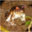

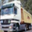

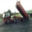

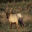

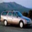

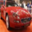

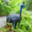

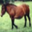

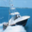

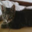

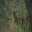

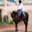

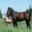

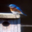

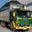

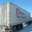

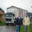

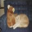

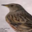

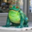

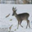

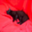

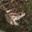

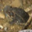

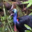

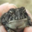

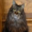

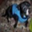

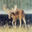

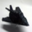

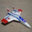

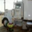

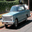

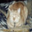

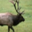

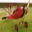

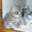

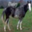

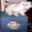

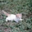

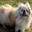

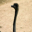

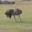

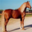

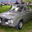

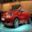

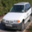

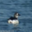

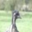

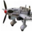

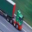

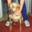

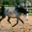

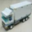

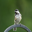

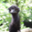

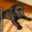

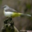

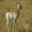

In [ ]:
from time import perf_counter

total_bits = 14
int_bits = 8

# todict = make_dict(total_bits, int_bits, 16, 11)
adict = OrderedDict()
for k, v in loaded_dict.items():
    adict[k] = v
adict['encoder.placeholder'] = loaded_dict['encoder.placeholder'][0:1, :, :, :, :]

dataiter = iter(make_data())
count = 0
correct = 0
times = []

batch_size = 1000
images_all = np.ndarray((96*batch_size, 32, 32))
labels_all = np.ndarray((batch_size))

tss = perf_counter()
for i in range(batch_size):
    images, labels = dataiter.next()
    img = np.array(images*255.0)[0].transpose(1, 2, 0).astype(np.uint8)
    display(Image.fromarray(img))
    ts = perf_counter()
    predict, encoding_out = net(images.numpy(), adict)
    tt = perf_counter()
    times.append(tt - ts)
    for c in range(96):
        for row in range(32):
            for col in range(32):
                images_all[i*96 + c][row][col] = encoding_out[0][c][row][col]
    labels_all[i] = labels.numpy()[0]
    if labels.numpy()[0] == predict:
        correct += 1
    count += 1
ttt = perf_counter()
print('Fixed<%d, %d>'%(total_bits, int_bits))
print(correct/count)
# print(count)
print(sum(times)/count)
print()

# for total_bits in range(10, 17, 2):
#     for int_bits in range(6, 11, 2):
#         todict = make_dict(total_bits, int_bits, 16, 11)
#         dataiter = iter(make_data())
#         count = 0
#         correct = 0
#         times = []
        
#         tss = perf_counter()
#         for i in range(1250):
#             images, labels = dataiter.next()
#             ts = perf_counter()
#             predict = net(images.numpy(), todict)
#             tt = perf_counter()
#             times.append(tt - ts)
#             if labels.numpy()[0] == predict:
#                 correct += 1
#             count += 1
#         ttt = perf_counter()
#         print('Fixed<%d, %d>'%(total_bits, int_bits))
#         print(correct/count)
#         # print(count)
#         print(sum(times)/count)
#         print()

In [ ]:
np.save('labels.npy', labels_all)
print(labels_all)
np.save('encoding_out.npy', images_all)
print(images_all)